PMCMC sampling...  25%|█████████                         |  ETA: 0:04:35

Iteration 500: ρ = 0.754, λ = 0.906, σ_ε = 1.213, σ_ξ = 0.257, σ_κ = 0.548, acceptance = 0.566


PMCMC sampling...  50%|█████████████████                 |  ETA: 0:02:59

Iteration 1000: ρ = 0.926, λ = 1.082, σ_ε = 1.187, σ_ξ = 0.315, σ_κ = 0.44, acceptance = 0.511


PMCMC sampling...  75%|██████████████████████████        |  ETA: 0:01:31

Iteration 1500: ρ = 0.931, λ = 0.998, σ_ε = 1.036, σ_ξ = 0.257, σ_κ = 0.324, acceptance = 0.475


PMCMC sampling... 100%|██████████████████████████████████| Time: 0:05:55


Iteration 2000: ρ = 0.93, λ = 0.953, σ_ε = 1.061, σ_ξ = 0.317, σ_κ = 0.357, acceptance = 0.45
Final acceptance rate: 0.45
Estimated ρ:         0.929 (true: 0.9)
Estimated λ:         0.973 (true: 1.0471975511965976)
Estimated σ_ε:       1.109 (true: 1.0)
Estimated σ_ξ:       0.312 (true: 0.3)
Estimated σ_κ:       0.384 (true: 0.5)


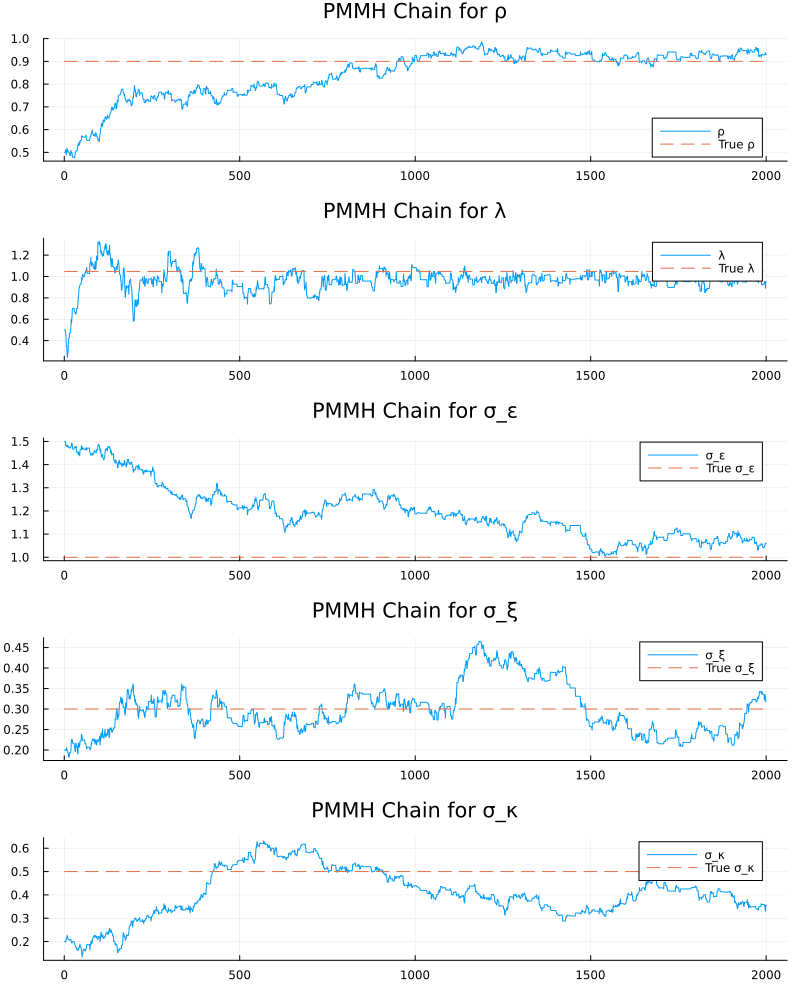

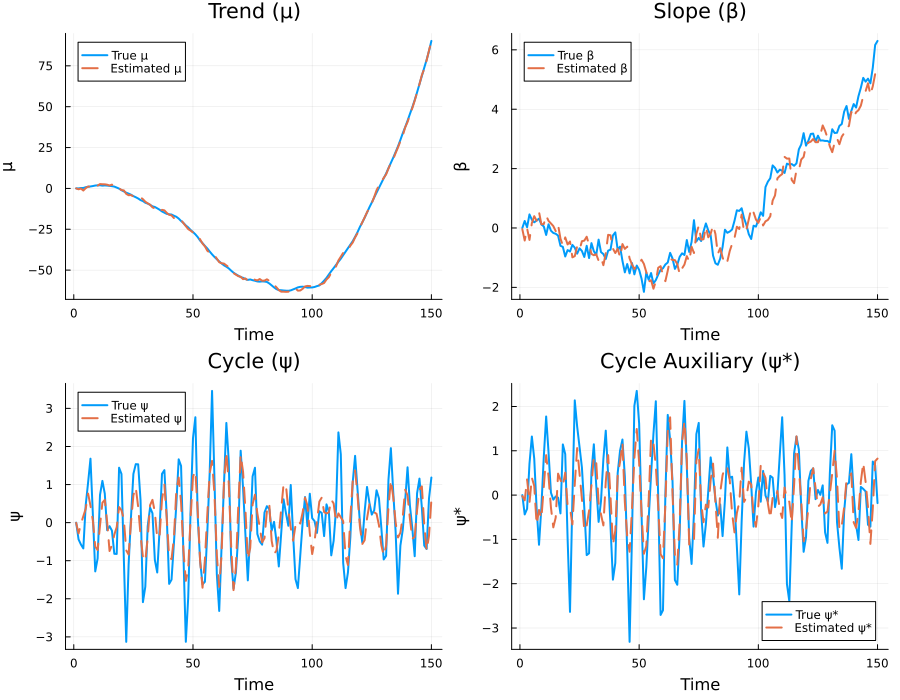

In [1]:
using Random
using Distributions
using StatsBase
using Plots
using ProgressMeter

# ================================
# 1. Generate Synthetic Data for the New Model
# ================================

Random.seed!(42)

# True parameters for the state-space model
true_rho           = 0.9            # damping factor for the cycle (should be in (0,1))
true_lambda_c      = π/3            # cycle frequency (radians), between 0 and π
true_sigma_epsilon = 1.0            # observation noise std
true_sigma_xi      = 0.3            # trend drift noise std
true_sigma_kappa   = 0.5            # cyclical shock noise std

T = 150  # number of time steps

# Allocate arrays for the states and observations
mu_true      = zeros(T)
beta_true    = zeros(T)
psi_true     = zeros(T)
psi_star_true= zeros(T)
y_obs       = zeros(T)

# Initial states (set to zero or small random values)
mu_true[1]       = 0.0
beta_true[1]     = 0.0
psi_true[1]      = 0.0
psi_star_true[1] = 0.0

# Precompute rotation matrix for the cycle
rot = [cos(true_lambda_c) sin(true_lambda_c);
       -sin(true_lambda_c) cos(true_lambda_c)]

# Generate the data recursively (t = 1 already set; simulate for t = 2:T)
for t in 2:T
    # Trend updates:
    mu_true[t]   = mu_true[t-1] + beta_true[t-1]
    beta_true[t] = beta_true[t-1] + rand(Normal(0, true_sigma_xi))
    
    # Cycle update:
    cycle_prev = [psi_true[t-1], psi_star_true[t-1]]
    noise = rand(Normal(0, true_sigma_kappa), 2)
    cycle_new = true_rho * (rot * cycle_prev) + noise
    psi_true[t]      = cycle_new[1]
    psi_star_true[t] = cycle_new[2]
    
    # Observation equation:
    y_obs[t] = mu_true[t] + psi_true[t] + rand(Normal(0, true_sigma_epsilon))
end

# ================================
# 2. Unified Particle Filter Function
# ================================
"""
    particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500, return_states=false)

Runs a particle filter for the state-space model:
  
  Trend:
    μₜ = μₜ₋₁ + βₜ₋₁
    βₜ = βₜ₋₁ + ξₜ, ξₜ ~ N(0, σ_ξ)
  
  Cycle (first order):
    [ψₜ, ψₜ*]' = ρ * R(λ) * [ψₜ₋₁, ψₜ₋₁*]' + [κₜ, κₜ*]', κₜ, κₜ* ~ N(0, σ_κ)
  
  Observation:
    yₜ = μₜ + ψₜ + εₜ, εₜ ~ N(0, σ_ε)

If `return_states` is true, the function returns a named tuple with filtered state estimates 
(for μ, β, ψ, and ψ*) along with the log-likelihood. Otherwise, it only returns the log-likelihood.
"""
function particle_filter(y_obs, ρ, λ, σ_ε, σ_ξ, σ_κ; N=500, return_states=false)
    T = length(y_obs)
    # Allocate matrices for each state component (time x particles)
    particles_mu      = zeros(T, N)
    particles_beta    = zeros(T, N)
    particles_psi     = zeros(T, N)
    particles_psistar = zeros(T, N)
    weights = zeros(T, N)

    # For storing filtered (weighted mean) estimates
    filtered_mu      = zeros(T)
    filtered_beta    = zeros(T)
    filtered_psi     = zeros(T)
    filtered_psistar = zeros(T)

    log_likelihood = 0.0

    # Initialization: sample initial particles
    particles_mu[1, :]      = rand(Normal(0, 1), N)
    particles_beta[1, :]    = rand(Normal(0, 1), N)
    particles_psi[1, :]     = rand(Normal(0, 1), N)
    particles_psistar[1, :] = rand(Normal(0, 1), N)

    # Weight the initial particles using the observation likelihood:
    for i in 1:N
        mean_obs = particles_mu[1, i] + particles_psi[1, i]
        weights[1, i] = pdf(Normal(mean_obs, σ_ε), y_obs[1])
    end
    wsum = sum(weights[1, :])
    weights[1, :] ./= wsum
    log_likelihood += log(wsum / N)
    
    # Compute filtered estimates for t = 1:
    filtered_mu[1]      = sum(particles_mu[1, :] .* weights[1, :])
    filtered_beta[1]    = sum(particles_beta[1, :] .* weights[1, :])
    filtered_psi[1]     = sum(particles_psi[1, :] .* weights[1, :])
    filtered_psistar[1] = sum(particles_psistar[1, :] .* weights[1, :])

    # Precompute the rotation matrix for the cycle update
    rot = [cos(λ) sin(λ); -sin(λ) cos(λ)]

    for t in 2:T
        # Resample indices based on weights from time t-1
        indices = sample(1:N, Weights(weights[t-1, :]), N, replace=true)

        for i in 1:N
            # Retrieve resampled states:
            μ_prev   = particles_mu[t-1, indices[i]]
            β_prev   = particles_beta[t-1, indices[i]]
            ψ_prev   = particles_psi[t-1, indices[i]]
            ψs_prev  = particles_psistar[t-1, indices[i]]

            # Trend update:
            μ_new = μ_prev + β_prev
            β_new = β_prev + rand(Normal(0, σ_ξ))

            # Cycle update:
            cycle_prev = [ψ_prev, ψs_prev]
            noise = rand(Normal(0, σ_κ), 2)
            cycle_new = ρ * (rot * cycle_prev) + noise
            ψ_new  = cycle_new[1]
            ψs_new = cycle_new[2]

            # Store new states:
            particles_mu[t, i]      = μ_new
            particles_beta[t, i]    = β_new
            particles_psi[t, i]     = ψ_new
            particles_psistar[t, i] = ψs_new

            # Compute weight based on observation likelihood:
            mean_obs = μ_new + ψ_new
            weights[t, i] = pdf(Normal(mean_obs, σ_ε), y_obs[t])
        end

        # Normalize weights:
        wsum = sum(weights[t, :])
        if wsum == 0
            weights[t, :] .= 1.0 / N
        else
            weights[t, :] ./= wsum
        end

        # Update log-likelihood:
        log_likelihood += log(wsum / N)

        # Compute filtered estimates:
        filtered_mu[t]      = sum(particles_mu[t, :] .* weights[t, :])
        filtered_beta[t]    = sum(particles_beta[t, :] .* weights[t, :])
        filtered_psi[t]     = sum(particles_psi[t, :] .* weights[t, :])
        filtered_psistar[t] = sum(particles_psistar[t, :] .* weights[t, :])
    end

    if return_states
        return log_likelihood, (mu = filtered_mu, beta = filtered_beta, psi = filtered_psi, psi_star = filtered_psistar)
    else
        return log_likelihood
    end
end

# ================================
# 3. PMMH to Estimate (ρ, λ, σ_ε, σ_ξ, σ_κ)
# ================================
"""
    PMMH(y_obs; n_iter=3000, N=500)

Runs the Particle Marginal Metropolis–Hastings (PMMH) algorithm to estimate the
parameters ρ, λ, σ_ε, σ_ξ, and σ_κ of the state-space model.

Priors:
  σ_ε ~ Exponential(1)
  σ_ξ ~ Exponential(1)
  σ_κ ~ Exponential(1)
  ρ ~ Uniform(0,1)
  λ ~ Uniform(0, π)

Returns a tuple:
 (ρ_samples, λ_samples, σ_ε_samples, σ_ξ_samples, σ_κ_samples, loglikelihoods)
"""
function PMMH(y_obs; n_iter=3000, N=500)
    # Arrays to store samples
    rho_samples           = zeros(n_iter)
    lambda_samples        = zeros(n_iter)
    sigma_epsilon_samples = zeros(n_iter)
    sigma_xi_samples      = zeros(n_iter)
    sigma_kappa_samples   = zeros(n_iter)
    loglikelihoods        = zeros(n_iter)

    # Initialize parameters (choose valid starting values)
    rho_current           = 0.5
    lambda_current        = 0.5       # in radians, between 0 and π
    sigma_epsilon_current = 1.5
    sigma_xi_current      = 0.2
    sigma_kappa_current   = 0.2

    # Run the particle filter to obtain the initial log-likelihood
    ll_current = particle_filter(y_obs, rho_current, lambda_current, sigma_epsilon_current, sigma_xi_current, sigma_kappa_current; N=N)

    # Store initial values:
    rho_samples[1]           = rho_current
    lambda_samples[1]        = lambda_current
    sigma_epsilon_samples[1] = sigma_epsilon_current
    sigma_xi_samples[1]      = sigma_xi_current
    sigma_kappa_samples[1]   = sigma_kappa_current
    loglikelihoods[1]        = ll_current

    # Proposal standard deviations for random-walk proposals
    prop_std_rho    = 0.01
    prop_std_lambda = 0.05
    prop_std_ε      = 0.01
    prop_std_ξ      = 0.01
    prop_std_κ      = 0.01

    accept_count = 0
    @showprogress 1 "PMCMC sampling..." for i in 2:n_iter
        # Propose new parameters via a random-walk:
        rho_proposal           = rho_current + randn() * prop_std_rho
        lambda_proposal        = lambda_current + randn() * prop_std_lambda
        sigma_epsilon_proposal = sigma_epsilon_current + randn() * prop_std_ε
        sigma_xi_proposal      = sigma_xi_current + randn() * prop_std_ξ
        sigma_kappa_proposal   = sigma_kappa_current + randn() * prop_std_κ

        # Enforce parameter constraints:
        if (rho_proposal <= 0 || rho_proposal >= 1 ||
            lambda_proposal <= 0 || lambda_proposal >= π ||
            sigma_epsilon_proposal <= 0 || sigma_xi_proposal <= 0 || sigma_kappa_proposal <= 0)
            # Reject proposal by keeping current parameters
            rho_samples[i]           = rho_current
            lambda_samples[i]        = lambda_current
            sigma_epsilon_samples[i] = sigma_epsilon_current
            sigma_xi_samples[i]      = sigma_xi_current
            sigma_kappa_samples[i]   = sigma_kappa_current
            loglikelihoods[i]        = ll_current
            continue
        end

        # Run particle filter for the proposed parameters:
        ll_proposal = particle_filter(y_obs, rho_proposal, lambda_proposal, sigma_epsilon_proposal, sigma_xi_proposal, sigma_kappa_proposal; N=N)

        # Compute log-priors:
        # For σ's, we use Exponential(1) priors; for ρ and λ, Uniform priors.
        log_prior_current = log(pdf(Exponential(1), sigma_epsilon_current)) +
                            log(pdf(Exponential(1), sigma_xi_current)) +
                            log(pdf(Exponential(1), sigma_kappa_current)) +
                            log(1.0) + log(1.0/π)  # ρ ~ Uniform(0,1) and λ ~ Uniform(0,π)
        log_prior_proposal = log(pdf(Exponential(1), sigma_epsilon_proposal)) +
                             log(pdf(Exponential(1), sigma_xi_proposal)) +
                             log(pdf(Exponential(1), sigma_kappa_proposal)) +
                             log(1.0) + log(1.0/π)

        # (Optional: if you want to ignore the priors, set them to zero)
        log_prior_current = 0
        log_prior_proposal = 0

        log_alpha = (ll_proposal + log_prior_proposal) - (ll_current + log_prior_current)
        if log(rand()) < log_alpha
            rho_current           = rho_proposal
            lambda_current        = lambda_proposal
            sigma_epsilon_current = sigma_epsilon_proposal
            sigma_xi_current      = sigma_xi_proposal
            sigma_kappa_current   = sigma_kappa_proposal
            ll_current            = ll_proposal
            accept_count         += 1
        end

        rho_samples[i]           = rho_current
        lambda_samples[i]        = lambda_current
        sigma_epsilon_samples[i] = sigma_epsilon_current
        sigma_xi_samples[i]      = sigma_xi_current
        sigma_kappa_samples[i]   = sigma_kappa_current
        loglikelihoods[i]        = ll_current

        if mod(i, 500) == 0
            println("Iteration $i: ρ = $(round(rho_current, digits=3)), λ = $(round(lambda_current, digits=3)), σ_ε = $(round(sigma_epsilon_current, digits=3)), σ_ξ = $(round(sigma_xi_current, digits=3)), σ_κ = $(round(sigma_kappa_current, digits=3)), acceptance = $(round(accept_count/i, digits=3))")
        end
    end

    println("Final acceptance rate: $(round(accept_count/n_iter, digits=3))")
    return rho_samples, lambda_samples, sigma_epsilon_samples, sigma_xi_samples, sigma_kappa_samples, loglikelihoods
end

# ================================
# 4. Run PMMH and Estimate Parameters
# ================================

n_iter = 2000
rho_chain, lambda_chain, sigma_epsilon_chain, sigma_xi_chain, sigma_kappa_chain, ll_chain = 
    PMMH(y_obs; n_iter=n_iter, N=2000)

# Discard burn-in (e.g., first 2000 iterations)
burn_in = 1000
est_rho           = mean(rho_chain[burn_in+1:end])
est_lambda        = mean(lambda_chain[burn_in+1:end])
est_sigma_epsilon = mean(sigma_epsilon_chain[burn_in+1:end])
est_sigma_xi      = mean(sigma_xi_chain[burn_in+1:end])
est_sigma_kappa   = mean(sigma_kappa_chain[burn_in+1:end])

println("Estimated ρ:         $(round(est_rho, digits=3)) (true: $(true_rho))")
println("Estimated λ:         $(round(est_lambda, digits=3)) (true: $(true_lambda_c))")
println("Estimated σ_ε:       $(round(est_sigma_epsilon, digits=3)) (true: $(true_sigma_epsilon))")
println("Estimated σ_ξ:       $(round(est_sigma_xi, digits=3)) (true: $(true_sigma_xi))")
println("Estimated σ_κ:       $(round(est_sigma_kappa, digits=3)) (true: $(true_sigma_kappa))")

# ================================
# 5. Obtain State Estimates Using the Same Particle Filter
# ================================
ll_final, state_estimates = particle_filter(y_obs, est_rho, est_lambda, est_sigma_epsilon, est_sigma_xi, est_sigma_kappa; N=2000, return_states=true)

# ================================
# 6. Plot the Parameter Chains
# ================================

p1 = plot(rho_chain, label="ρ", title="PMMH Chain for ρ")
plot!(p1, fill(true_rho, length(rho_chain)), label="True ρ", linestyle=:dash)

p2 = plot(lambda_chain, label="λ", title="PMMH Chain for λ")
plot!(p2, fill(true_lambda_c, length(lambda_chain)), label="True λ", linestyle=:dash)

p3 = plot(sigma_epsilon_chain, label="σ_ε", title="PMMH Chain for σ_ε")
plot!(p3, fill(true_sigma_epsilon, length(sigma_epsilon_chain)), label="True σ_ε", linestyle=:dash)

p4 = plot(sigma_xi_chain, label="σ_ξ", title="PMMH Chain for σ_ξ")
plot!(p4, fill(true_sigma_xi, length(sigma_xi_chain)), label="True σ_ξ", linestyle=:dash)

p5 = plot(sigma_kappa_chain, label="σ_κ", title="PMMH Chain for σ_κ")
plot!(p5, fill(true_sigma_kappa, length(sigma_kappa_chain)), label="True σ_κ", linestyle=:dash)

# Combine and display parameter chain plots
plot(p1, p2, p3, p4, p5, layout=(5,1), size=(800, 1000))
display(plot(p1, p2, p3, p4, p5, layout=(5,1), size=(800, 1000)))

# ================================
# 7. Plot the Estimated States Against the True States
# ================================

T_range = 1:T

# Plot for the Trend (μ)
p_mu = plot(T_range, mu_true, label="True μ", lw=2, title="Trend (μ)", xlabel="Time", ylabel="μ")
plot!(p_mu, T_range, state_estimates.mu, label="Estimated μ", lw=2, linestyle=:dash)

# Plot for the Slope (β)
p_beta = plot(T_range, beta_true, label="True β", lw=2, title="Slope (β)", xlabel="Time", ylabel="β")
plot!(p_beta, T_range, state_estimates.beta, label="Estimated β", lw=2, linestyle=:dash)

# Plot for the Cycle (ψ)
p_psi = plot(T_range, psi_true, label="True ψ", lw=2, title="Cycle (ψ)", xlabel="Time", ylabel="ψ")
plot!(p_psi, T_range, state_estimates.psi, label="Estimated ψ", lw=2, linestyle=:dash)

# Plot for the Cycle Auxiliary (ψ*)
p_psistar = plot(T_range, psi_star_true, label="True ψ*", lw=2, title="Cycle Auxiliary (ψ*)", xlabel="Time", ylabel="ψ*")
plot!(p_psistar, T_range, state_estimates.psi_star, label="Estimated ψ*", lw=2, linestyle=:dash)

# Combine plots in a 2x2 layout
plot(p_mu, p_beta, p_psi, p_psistar, layout=(2,2), size=(900,700))


PMCMC sampling...  25%|█████████                         |  ETA: 0:09:34

Iteration 500: θ = [0.547, 1.061, 1.712, 0.294, 0.388], acceptance rate = 0.116


PMCMC sampling...  50%|█████████████████                 |  ETA: 0:06:41

Iteration 1000: θ = [0.807, 1.129, 1.942, 0.318, 0.598], acceptance rate = 0.229


PMCMC sampling...  75%|██████████████████████████        |  ETA: 0:03:30

Iteration 1500: θ = [0.92, 1.11, 1.878, 0.206, 0.469], acceptance rate = 0.253


PMCMC sampling... 100%|██████████████████████████████████| Time: 0:14:25


Iteration 2000: θ = [0.896, 1.028, 1.821, 0.105, 0.587], acceptance rate = 0.217
Final acceptance rate: 0.217
Estimated θ: [0.894, 1.074, 1.873, 0.199, 0.51]
True θ:      [0.9, 1.0471975511965976, 1.0, 0.3, 0.5]


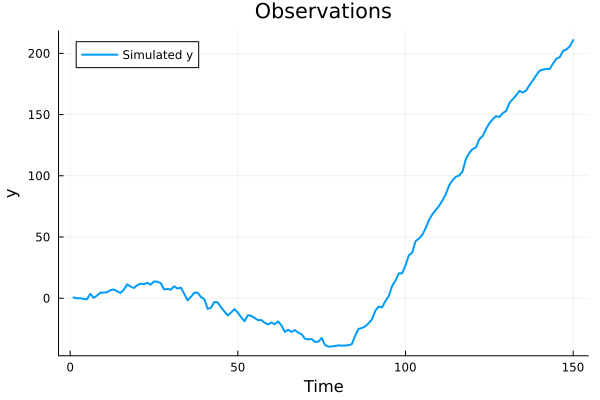

LoadError: type Array has no field x

In [2]:
using Random
using Distributions
using StatsBase
using LinearAlgebra
using Plots
using ProgressMeter

# ============================================================
# 1. Define the uni_state_space Model
# ============================================================
"""
    uni_state_space(θ, cycle_order, σʸ)

Defines the state-space representation for a univariate model with trend and cycle.
Parameters:
  θ = [ρ, λ_c, σ_ε, σ_ξ, σ_κ]
  cycle_order : number of cycle blocks (set to 1 for the basic model)
  σʸ          : a one-element vector for scaling (e.g., [1.0])
Returns:
  Z, H, Tmat, R, Q, P_diffuse
where
  - Measurement: yₜ = Z xₜ + εₜ, εₜ ~ N(0, H)
  - Transition: xₜ = Tmat xₜ₋₁ + R wₜ, wₜ ~ N(0, Q)
  - P_diffuse: diffuse prior for the nonstationary (trend) states.
"""
function uni_state_space(θ, cycle_order, σʸ)
    # Unpack parameters
    ρ   = θ[1]
    λ_c = θ[2]
    σ_ε = θ[3]
    σ_ξ = θ[4]
    σ_κ = θ[5]
    σʸ = σʸ[1]

    # Total state dimension: 2 for trend and 2 per cycle block.
    state_dim = 2 + 2*cycle_order

    ##########################
    # 1. Measurement Equation
    ##########################
    # yₜ = uₜ + ψ_{max,t} + εₜ, where uₜ = state[1] and ψ_{max,t} = state[3]
    Z = zeros(1, state_dim)
    Z[1, 1] = 1    # uₜ
    Z[1, 3] = 1    # ψ_{max,t}
    # Rescale by σʸ:
    Z .= Z ./ σʸ
    # Measurement error covariance (scalar):
    H = [σ_ε / (σʸ^2)]

    ##########################
    # 2. Transition Equation
    ##########################
    Tmat = zeros(state_dim, state_dim)
    # Trend equations:
    # uₜ = uₜ₋₁ + βₜ₋₁,  βₜ = βₜ₋₁ (shock enters later)
    Tmat[1,1] = 1; Tmat[1,2] = 1
    Tmat[2,2] = 1
    # Cycle equations:
    for i in 1:cycle_order
        idx = 2 + 2*(i-1) + 1  # starting index for block i
        # Rotation part:
        Tmat[idx, idx]     = ρ * cos(λ_c)
        Tmat[idx, idx+1]   = ρ * sin(λ_c)
        Tmat[idx+1, idx]   = -ρ * sin(λ_c)
        Tmat[idx+1, idx+1] = ρ * cos(λ_c)
        # For blocks not at the lowest order, add lower block effect:
        if i < cycle_order
            next_idx = idx + 2
            Tmat[idx, next_idx]   = 1
            Tmat[idx+1, next_idx+1] = 1
        end
    end

    ##########################
    # 3. Selection and Process Noise
    ##########################
    # There are three shocks:
    #   - ξₜ (trend drift) entering βₜ,
    #   - κₜ and κₜ* (cycle shocks) entering the lowest cycle block.
    R = zeros(state_dim, 3)
    R[2, 1] = 1  # βₜ gets ξₜ
    # Lowest cycle block indices:
    idx_low = 2 + 2*(cycle_order - 1) + 1
    R[idx_low,   2] = 1  # ψ_{max,t} gets κₜ
    R[idx_low+1, 3] = 1  # ψ^*_{max,t} gets κₜ*

    # Process noise covariance matrix Q:
    Q = zeros(3,3)
    Q[1,1] = σ_ξ
    Q[2,2] = σ_κ
    Q[3,3] = σ_κ

    # Diffuse prior for nonstationary trend states (set for states 1 and 2):
    P_diffuse = zeros(state_dim, state_dim)
    P_diffuse[1:2,1:2] = Matrix(I, 2, 2)

    return Z, H, Tmat, R, Q, P_diffuse
end

# ============================================================
# 2. Simulate Data Using uni_state_space
# ============================================================
"""
    simulate_uni_state_space(θ, cycle_order, σy, T)

Simulates states and observations from the uni_state_space model.
Returns:
  x (state trajectories, state_dim x T) and y (observations)
"""
function simulate_uni_state_space(θ, cycle_order, σy, T)
    Z, H, Tmat, R, Q, P_diffuse = uni_state_space(θ, cycle_order, σy)
    state_dim = size(Tmat, 1)
    x = zeros(state_dim, T)
    y = zeros(T)
    # Initialize state (here we set to zero; alternatively sample from a diffuse prior)
    x[:,1] .= 0.0
    # Simulate states recursively
    for t in 2:T
        w = rand(MvNormal(zeros(3), Q))
        x[:,t] = Tmat * x[:,t-1] + R * w
    end
    # Simulate observations: yₜ = Z * xₜ + εₜ, εₜ ~ N(0, H)
    for t in 1:T
        eps = rand(Normal(0, sqrt(H[1])))
        y[t] = (Z * x[:,t])[1] + eps
    end
    return x, y
end

# Set true parameters (same as before)
true_θ = [0.9, π/3, 1.0, 0.3, 0.5]   # [ρ, λ_c, σ_ε, σ_ξ, σ_κ]
cycle_order = 1
σy = [1.0]
T = 150

# Simulate data using the uni_state_space model
x_sim, y_sim = simulate_uni_state_space(true_θ, cycle_order, σy, T)

# ============================================================
# 3. Particle Filter for the uni_state_space Model
# ============================================================
"""
    particle_filter_uni(y_obs, θ, cycle_order, σy; N=500, return_states=false)

A bootstrap particle filter for the uni_state_space model.
Uses the state-space matrices from uni_state_space(θ, cycle_order, σy).

Returns:
  - If return_states == false: log_likelihood
  - Else: (log_likelihood, filtered_states) where filtered_states is a named tuple
          with field 'x' containing the filtered state mean at each time step.
"""
function particle_filter_uni(y_obs, θ, cycle_order, σy; N=500, return_states=false)
    T = length(y_obs)
    # Obtain state-space matrices from uni_state_space:
    Z, H, Tmat, R, Q, P_diffuse = uni_state_space(θ, cycle_order, σy)
    state_dim = size(Tmat, 1)
    
    # Allocate particles: each column is a particle state vector
    particles = zeros(state_dim, N, T)
    weights = zeros(T, N)
    # For filtered state estimates (weighted means)
    filtered_state = zeros(state_dim, T)
    
    log_likelihood = 0.0

    # Initialization: for simplicity, we initialize all particles to zero
    for i in 1:N
        particles[:, i, 1] .= 0.0
    end

    # Compute weights at time 1:
    for i in 1:N
        mean_obs = (Z * particles[:, i, 1])[1]
        weights[1, i] = pdf(Normal(mean_obs, sqrt(H[1])), y_obs[1])
    end
    sumw = sum(weights[1, :])
    weights[1, :] ./= (sumw + eps())
    log_likelihood += log(sumw / N)
    # Filtered state at t=1:
    for d in 1:state_dim
        filtered_state[d, 1] = sum(particles[d, :, 1] .* weights[1, :])
    end

    # Propagate particles:
    for t in 2:T
        # Resample indices based on previous weights:
        idxs = sample(1:N, Weights(weights[t-1, :]), N, replace=true)
        for i in 1:N
            x_prev = particles[:, idxs[i], t-1]
            w = rand(MvNormal(zeros(3), Q))
            # Propagate:
            x_new = Tmat * x_prev + R * w
            particles[:, i, t] = x_new
            # Compute likelihood: y_t ~ N(Z*x_new, H)
            mean_obs = (Z * x_new)[1]
            weights[t, i] = pdf(Normal(mean_obs, sqrt(H[1])), y_obs[t])
        end
        # Normalize weights:
        sumw = sum(weights[t, :])
        if sumw == 0
            weights[t, :] .= 1.0 / N
        else
            weights[t, :] ./= sumw
        end
        log_likelihood += log(sumw / N)
        # Filtered state estimate (weighted mean)
        for d in 1:state_dim
            filtered_state[d, t] = sum(particles[d, :, t] .* weights[t, :])
        end
    end

    if return_states
        return log_likelihood, (x = filtered_state)
    else
        return log_likelihood
    end
end

# ============================================================
# 4. PMMH for the uni_state_space Model
# ============================================================
"""
    PMMH_uni(y_obs; n_iter=3000, N=500, cycle_order, σy)

Runs the Particle Marginal Metropolis–Hastings (PMMH) algorithm to estimate the
parameters θ = [ρ, λ_c, σ_ε, σ_ξ, σ_κ] for the uni_state_space model.
Uses the particle filter defined above.
Returns:
  (θ_samples, loglikelihoods)
where θ_samples is a matrix with each row a sample of θ.
"""
function PMMH_uni(y_obs; n_iter=3000, N=500, cycle_order, σy)
    # Store samples in a matrix (n_iter x 5)
    θ_samples = zeros(n_iter, 5)
    loglikelihoods = zeros(n_iter)
    
    # Initialize parameters (choose valid starting values)
    θ_current = [0.5, 0.5, 1.5, 0.2, 0.2]
    
    # Run the particle filter for the initial parameters:
    ll_current = particle_filter_uni(y_obs, θ_current, cycle_order, σy; N=N)
    
    θ_samples[1, :] = θ_current
    loglikelihoods[1] = ll_current
    
    # Proposal standard deviations for random-walk proposals:
    prop_std = [0.01, 0.05, 0.01, 0.01, 0.01]
    
    accept_count = 0
    
    @showprogress 1 "PMCMC sampling..." for i in 2:n_iter
        # Propose new parameters:
        θ_proposal = θ_current .+ randn(5) .* prop_std
        # Enforce constraints:
        if θ_proposal[1] <= 0 || θ_proposal[1] >= 1 ||
           θ_proposal[2] <= 0 || θ_proposal[2] >= π ||
           any(θ_proposal[3:5] .<= 0)
            θ_samples[i, :] = θ_current
            loglikelihoods[i] = ll_current
            continue
        end
        
        ll_proposal = particle_filter_uni(y_obs, θ_proposal, cycle_order, σy; N=N)
        
        # (For simplicity, we use flat priors so that the acceptance ratio is just likelihood ratio)
        log_alpha = ll_proposal - ll_current
        if log(rand()) < log_alpha
            θ_current = θ_proposal
            ll_current = ll_proposal
            accept_count += 1
        end
        θ_samples[i, :] = θ_current
        loglikelihoods[i] = ll_current
        
        if mod(i, 500) == 0
            println("Iteration $i: θ = $(round.(θ_current, digits=3)), acceptance rate = $(round(accept_count/i, digits=3))")
        end
    end
    println("Final acceptance rate: $(round(accept_count/n_iter, digits=3))")
    return θ_samples, loglikelihoods
end

# ============================================================
# 5. Run PMMH to Estimate Parameters from Simulated Data
# ============================================================
n_iter = 2000
θ_chain, ll_chain = PMMH_uni(y_sim; n_iter=n_iter, N=2000, cycle_order=cycle_order, σy=σy)

# Discard burn-in (for example, first 2000 iterations)
burn_in = 1000
est_θ = mean(θ_chain[burn_in+1:end, :], dims=1)
println("Estimated θ: ", round.(vec(est_θ), digits=3))
println("True θ:      ", true_θ)

# ============================================================
# 6. Obtain Filtered State Estimates Using the Estimated Parameters
# ============================================================
ll_final, filtered_uni = particle_filter_uni(y_sim, vec(est_θ), cycle_order, σy; N=2000, return_states=true)

# ============================================================
# 7. Plot Results
# ============================================================
T_range = 1:T

# Plot the simulated observations vs. filtered observations (one-step prediction)
p_obs = plot(T_range, y_sim, label="Simulated y", lw=2, title="Observations", xlabel="Time", ylabel="y")
display(p_obs)

# For filtered state estimates, recall that in uni_state_space:
# x[1,:] = u_t (trend), x[2,:] = β_t, x[3,:] = ψ_max,t, x[4,:] = ψ^*_max,t.
filtered_states = filtered_uni.x

p_trend = plot(T_range, filtered_states[1, :], label="Filtered u_t", lw=2, title="Filtered Trend (u_t)", xlabel="Time", ylabel="u_t")
display(p_trend)

# (Optional) Plot PMMH parameter chains:
p1 = plot(θ_chain[:,1], label="ρ", title="PMMH Chain for ρ")
plot!(p1, fill(true_θ[1], length(θ_chain[:,1])), label="True ρ", linestyle=:dash)

p2 = plot(θ_chain[:,2], label="λ_c", title="PMMH Chain for λ_c")
plot!(p2, fill(true_θ[2], length(θ_chain[:,2])), label="True λ_c", linestyle=:dash)

p3 = plot(θ_chain[:,3], label="σ_ε", title="PMMH Chain for σ_ε")
plot!(p3, fill(true_θ[3], length(θ_chain[:,3])), label="True σ_ε", linestyle=:dash)

p4 = plot(θ_chain[:,4], label="σ_ξ", title="PMMH Chain for σ_ξ")
plot!(p4, fill(true_θ[4], length(θ_chain[:,4])), label="True σ_ξ", linestyle=:dash)

p5 = plot(θ_chain[:,5], label="σ_κ", title="PMMH Chain for σ_κ")
plot!(p5, fill(true_θ[5], length(θ_chain[:,5])), label="True σ_κ", linestyle=:dash)

plot(p1, p2, p3, p4, p5, layout=(5,1), size=(800, 1000))
display(plot(p1, p2, p3, p4, p5, layout=(5,1), size=(800, 1000)))
